# Project: decoding emotion and emotion regulation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import h5py
import pandas as pd
from plotnine import *

In [2]:
from nilearn import plotting
from nilearn.image import mean_img
from nilearn import image
from nilearn.input_data import NiftiMasker

C:\ProgramData\Miniconda3\lib\site-packages\nilearn\plotting\cm.py:159: MatplotlibDeprecationWarning: 
The revcmap function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use Colormap.reversed() instead.
  _cmaps_data[_cmapname_r] = _cm.revcmap(_cmapspec)


In [3]:
import os

os.chdir('C:/Users/tepzh/Desktop/psych253 downloads/project')
print(os.getcwd())

C:\Users\tepzh\Desktop\psych253 downloads\project


### Read and visualize sample functional data in a mask

In [155]:
mask_files = ['bilateral_Amygdala', 'anterior_cingulate', 'posterior_cingulate', 'frontal_pole', 'inferior_frontal_gyrus',
             'dlPFC', 'vlPFC', 'vmPFC', 'pre_SMA', 'insula']
mask_short_name = ['amy', 'acc', 'pcc', 'fp', 'ifg',
                  'dlpfc', 'vlpfc', 'vmpfc', 'pre_sma', 'insula']

for i in range(len(mask_files)):
    print('plotting', mask_files[i])
    mask = 'ROIs/' + mask_files[i] + '_mask.nii.gz'
    plotting.plot_roi(mask, output_file='figures/roi_' + mask_short_name[i] + '.png')


plotting insula


### Read real functional data in masks

In [4]:
# read nifti data of 1 run
def read_and_convert_fmri_run_data(subject, mask, run_num, trial_start_time=2, trial_end_time=14):
    """
    read fmri data of voxels in a mask of 1 run of 1 subject and convert them into a numpy array
    
    arguments:
        subject: subject ID 
        mask: mask name, options are 'bilateral_Amygdala', 'anterior_cingulate', 'frontal_pole', 'inferior_frontal_gyrus',
        'insula', 'mPFC', 'OFC', 'posterior_cingulate'
        run_num: run number, usually 1 to 5
        trial_start_time: for each trial, the start time (in seconds) you want to extract data
        trial_end_time: for each trial, the end time (inseconds) you want to extract data
        
    returns:
        a dict of 'data' (numpy array of shape (m, n) where m is the number of trials and n is the number of voxels in this mask) 
            and 'label' (a numpy array of shape (m,) where m is the number of trials; 
            the value being the type of each trial: neutral, negative-react, negative-regulate)
    """
    print('run', run_num, '...')
    subj_func_path = 'sub-Spieg'+ str(subject) + '/func/'
    run_file = subj_func_path + 'sub-Spieg' + str(subject) + '_task-ER_run-' + str(run_num) + \
                '_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    
    # read confounds
    if False:
        confounds_file = subj_func_path + 'sub-Spieg' + str(subject) + '_task-ER_run-' + str(run_num) +\
                        '_desc-confounds_regressors.tsv'
        confounds = pd.read_csv(confounds_file, sep='\t')
        confounds['framewise_displacement'][0] = 0
        # select confounds
        confounds = confounds[['framewise_displacement']]
        confounds = np.array(confounds)
    else:
        confounds = None
    
    # masker
    mask_file = 'ROIs/' + mask +'_mask.nii.gz'
    masker = NiftiMasker(mask_img=mask_file, standardize=False, detrend=False)
    fmri_run_masked = masker.fit_transform(run_file, confounds=confounds)    
    n_volumes = fmri_run_masked.shape[0]
    
    run_events = subj_func_path + 'run' + str(run_num)+ '_picture.csv'
    df_run_events = pd.read_csv(run_events)
    n_events = df_run_events.shape[0]
    df_run_events['trial_type'] = df_run_events['condition'].replace({'wat_ntr':'neutral', 
                                                                      'wat_IAPS_neg':'negative-react',  
                                                                      'wat_BC_neg':'negative-react', 
                                                                      'reap_IAPS_neg':'negative-regulate', 
                                                                      'reap_BC_neg':'negative-regulate'})
    # per trial: data from t = 2 to 16
    df_run_events['min_volume'] = (df_run_events['picture_time'] )/2
    df_run_events['max_volume'] = (df_run_events['picture_time'] + 16)/2    
    
    
#     # label data for each volume
#     trial_type = ['no_event']*n_volumes
#     trial_time = ['']*n_volumes
#     trial_idx = ['']*n_volumes
#     for i in range(n_volumes):
#         for j in range(n_events):
#             if i>df_run_events['min_volume'][j] and i<df_run_events['max_volume'][j]:
#                 trial_type[i] = df_run_events['trial_type'][j]
#                 trial_time[i] = (i - df_run_events['min_volume'][j])*2
#                 trial_idx[i] = j
#     df_run_info = pd.DataFrame({'type': trial_type,'trial': trial_idx, 'time': trial_time})
    
    
    run_trial_level = []
    for j in range(n_events):
        min_volume = df_run_events['min_volume'][j] + trial_start_time/2
        max_volume = df_run_events['min_volume'][j] + trial_end_time/2
        min_volume = int(np.ceil(min_volume))
        max_volume = int(np.ceil(max_volume))
#         print('event', j, 'volume:', min_volume, '-', max_volume)

        data_this_trial = fmri_run_masked[min_volume:max_volume].mean(axis = 0)
        run_trial_level.append(data_this_trial)

    run_trial_level = np.array(run_trial_level)
    # standardize data across voxels
    run_trial_level = stats.zscore(run_trial_level, axis = 0)
    
    results = {'data': run_trial_level, 'label': np.array(df_run_events['trial_type'])}
    
    return results


# read nifti data of multiple runs of 1 subject
def read_and_convert_fmri_subject_data(subject, mask, runs = 'all', 
                                       trial_start_time = 2, trial_end_time = 14, normalize = True):
    """
    read fmri data of voxels in a mask of multiple runs of 1 subject and convert them into a numpy array
    
    arguments:
        subject: subject ID 
        mask: mask name, options are 'bilateral_Amygdala', 'anterior_cingulate', 'frontal_pole', 'inferior_frontal_gyrus',
        'insula', 'mPFC', 'OFC', 'posterior_cingulate'
        runs: run numbers to extract data from; if 'all', extract all available runs
        trial_start_time: for each trial, the start time (in seconds) you want to extract data
        trial_end_time: for each trial, the end time (inseconds) you want to extract data
        normalize: whether to z-score data across voxels (observation-wise)
        
    returns:
        a dict of:
            'data' (numpy array of shape (m, n) where m is the number of trials and n is the number of voxels in this mask) 
            'label' (an array of shape (m,) where m is the number of trials; the value being the type of each trial: neutral, negative-react, negative-regulate)
            'run' (an array of shape (m,) indicating the run number of each trial)
    """    
    import glob
    
    print("processing", subject, mask)
    if runs == 'all':
        subj_func_path = 'sub-Spieg'+ str(subject) + '/func/'
        max_run = len(glob.glob(subj_func_path + 'run[0-9]_picture.csv'))
        runs = list(range(1, max_run + 1))
#         print(runs)
    
    subject_results =  {'data':[], 'label':[], 'run':[]}
    first_run = True
    for run in runs:
        run_results = read_and_convert_fmri_run_data(subject, mask, run, trial_start_time, trial_end_time)
        subject_results['data'].append(run_results['data'])
        subject_results['label'].extend(run_results['label'])
        subject_results['run'].extend([run] * (np.shape(run_results['data'])[0]))
#         print(np.shape(subject_results['data']))
    
    subject_results['data'] = np.array(subject_results['data'])
    subject_results['label'] = np.array(subject_results['label'])
    subject_results['run'] = np.array(subject_results['run'])
    # convert data from 3D to 2D array ((5, 23, 494) to (115, 494))
    subject_results['data'] = subject_results['data'].reshape((-1, subject_results['data'].shape[2]))
    if normalize:
        subject_results['data'] = stats.zscore(subject_results['data'], axis = 1)
    print('data shape:', np.shape(subject_results['data']))
    return subject_results


# convert data of all trials into trials for reactvity classification and regulation classification
def get_data_for_reactivity_regulation(data):
    """
    arguments:
        data: a dict of 'data', 'label', and 'run'
    """
    data_reactivity = {}
    data_reactivity['data'] = data['data'][data['label'][:] != 'negative-regulate', :]
    data_reactivity['label'] = data['label'][data['label'][:] != 'negative-regulate']
    data_reactivity['run'] = data['run'][data['label'][:] != 'negative-regulate']
    
    
    data_regulation = {}
    data_regulation['data'] = data['data'][data['label'][:] != 'neutral', :]
    data_regulation['label'] = data['label'][data['label'][:] != 'neutral']
    data_regulation['run'] = data['run'][data['label'][:] != 'neutral']
    
    return data_reactivity, data_regulation

In [6]:
# # read data of 16034
data_sub_16034 = {}

data_sub_16034['amy'] = read_and_convert_fmri_subject_data(16034, mask = 'bilateral_Amygdala', normalize = False,
                                                           trial_start_time = 2, trial_end_time = 14)

# data_sub_16034['insula'] = read_and_convert_fmri_subject_data(16034, mask = 'insula', normalize = False,
#                                                            trial_start_time = 2, trial_end_time = 14)

# data_sub_16034['vmpfc'] = read_and_convert_fmri_subject_data(16034, mask = 'vmPFC', normalize = False,
#                                                            trial_start_time = 2, trial_end_time = 14)


# data_sub_16034['dlpfc'] = read_and_convert_fmri_subject_data(16034, mask = 'dlPFC', normalize = False,
#                                                            trial_start_time = 2, trial_end_time = 14)

# data_sub_16034['vlpfc'] = read_and_convert_fmri_subject_data(16034, mask = 'vlPFC', normalize = False,
#                                                            trial_start_time = 2, trial_end_time = 14)

# data_sub_16034['pre_sma'] = read_and_convert_fmri_subject_data(16034, mask = 'pre_SMA', normalize = False,
#                                                            trial_start_time = 2, trial_end_time = 14)

# data_sub_16034['acc'] = read_and_convert_fmri_subject_data(16034, mask = 'anterior_cingulate', normalize = False,
#                                                            trial_start_time = 2, trial_end_time = 14)

# data_sub_16034['frontal_pole'] = read_and_convert_fmri_subject_data(16034, mask = 'frontal_pole', normalize = False,
#                                                            trial_start_time = 2, trial_end_time = 14)

# took forever to read this data
# data_sub_16034['gray_matter'] = read_and_convert_fmri_subject_data(16034, mask = 'gray_matter_example', normalize = False,
#                                                            trial_start_time = 2, trial_end_time = 14)

data_sub_16034['amy_reactivity'], data_sub_16034['amy_regulation'] = get_data_for_reactivity_regulation(data_sub_16034['amy'])
# data_sub_16034['insula_reactivity'], data_sub_16034['insula_regulation'] = get_data_for_reactivity_regulation(data_sub_16034['insula'])
# data_sub_16034['vmpfc_reactivity'], data_sub_16034['vmpfc_regulation'] = get_data_for_reactivity_regulation(data_sub_16034['vmpfc'])
# data_sub_16034['dlpfc_reactivity'], data_sub_16034['dlpfc_regulation'] = get_data_for_reactivity_regulation(data_sub_16034['dlpfc'])
# data_sub_16034['vlpfc_reactivity'], data_sub_16034['vlpfc_regulation'] = get_data_for_reactivity_regulation(data_sub_16034['vlpfc'])
# data_sub_16034['pre_sma_reactivity'], data_sub_16034['pre_sma_regulation'] = get_data_for_reactivity_regulation(data_sub_16034['pre_sma'])
# data_sub_16034['acc_reactivity'], data_sub_16034['acc_regulation'] = get_data_for_reactivity_regulation(data_sub_16034['acc'])
# data_sub_16034['frontal_pole_reactivity'], data_sub_16034['frontal_pole_regulation'] = get_data_for_reactivity_regulation(data_sub_16034['frontal_pole'])
# data_sub_16034['gray_matter_reactivity'], data_sub_16034['gray_matter_regulation'] = get_data_for_reactivity_regulation(data_sub_16034['gray_matter'])


processing 16034 bilateral_Amygdala
run 1 ...
run 2 ...
run 3 ...
run 4 ...
run 5 ...
data shape: (115, 494)


In [25]:
for t in range(2, 14, 2):
    print(t, '-', t+2, ' s')
    data_sub_16034['frontal_pole_' + str(t) + 's'] = read_and_convert_fmri_subject_data(16034, mask = 'frontal_pole', normalize = False,
                                                               trial_start_time = t, trial_end_time = t+2)
    data_sub_16034['frontal_pole_' + str(t) + 's_reactivity'], data_sub_16034['frontal_pole_' + str(t) + 's_regulation'] = get_data_for_reactivity_regulation(data_sub_16034['frontal_pole_' + str(t) + 's'])


In [26]:
# h5py start guide
# http://docs.h5py.org/en/stable/quick.html
# https://www.christopherlovell.co.uk/blog/2016/04/27/h5py-intro.html

# save data to hdf5 format
with h5py.File("sub-Spieg16034/func/ROI_data.hdf5", "r+") as subject_data:
#     # amygdala
#     subject_data_amy = subject_data.create_group('amy')
#     subject_data_amy.create_dataset("data", data=data_sub_16034['amy']['data'])
#     subject_data_amy.create_dataset("run", data=data_sub_16034['amy']['run'])    
#     dt = h5py.string_dtype() # strings in HDF5: https://docs.h5py.org/en/stable/strings.html
#     subject_data_amy.create_dataset("label", 
#                                     data= np.array(data_sub_16034['amy']['label'], dtype=h5py.string_dtype(encoding='utf-8')), 
#                                     dtype=dt)
#     # insula
#     subject_data.create_dataset("insula/data", data=data_sub_16034['insula']['data'])
#     subject_data.create_dataset("insula/run", data=data_sub_16034['insula']['run'])    
#     dt = h5py.string_dtype() # strings in HDF5: https://docs.h5py.org/en/stable/strings.html
#     subject_data.create_dataset("insula/label", 
#                                     data= np.array(data_sub_16034['insula']['label'], dtype=h5py.string_dtype(encoding='utf-8')), 
#                                     dtype=dt)
#     # vmPFC
#     subject_data.create_dataset("vmpfc/data", data=data_sub_16034['vmpfc']['data'])
#     subject_data.create_dataset("vmpfc/run", data=data_sub_16034['vmpfc']['run'])    
#     dt = h5py.string_dtype() # strings in HDF5: https://docs.h5py.org/en/stable/strings.html
#     subject_data.create_dataset("vmpfc/label", 
#                                     data= np.array(data_sub_16034['vmpfc']['label'], dtype=h5py.string_dtype(encoding='utf-8')), 
#                                     dtype=dt)
#     # vlPFC
#     subject_data.create_dataset("vlpfc/data", data=data_sub_16034['vlpfc']['data'])
#     subject_data.create_dataset("vlpfc/run", data=data_sub_16034['vlpfc']['run'])    
#     dt = h5py.string_dtype() # strings in HDF5: https://docs.h5py.org/en/stable/strings.html
#     subject_data.create_dataset("vlpfc/label", 
#                                     data= np.array(data_sub_16034['vlpfc']['label'], dtype=h5py.string_dtype(encoding='utf-8')), 
#                                     dtype=dt)
#     # dlPFC
#     subject_data.create_dataset("dlpfc/data", data=data_sub_16034['dlpfc']['data'])
#     subject_data.create_dataset("dlpfc/run", data=data_sub_16034['dlpfc']['run'])    
#     dt = h5py.string_dtype() # strings in HDF5: https://docs.h5py.org/en/stable/strings.html
#     subject_data.create_dataset("dlpfc/label", 
#                                     data= np.array(data_sub_16034['dlpfc']['label'], dtype=h5py.string_dtype(encoding='utf-8')), 
#                                     dtype=dt)
#     # ACC
#     subject_data.create_dataset("acc/data", data=data_sub_16034['acc']['data'])
#     subject_data.create_dataset("acc/run", data=data_sub_16034['acc']['run'])    
#     dt = h5py.string_dtype() # strings in HDF5: https://docs.h5py.org/en/stable/strings.html
#     subject_data.create_dataset("acc/label", 
#                                     data= np.array(data_sub_16034['acc']['label'], dtype=h5py.string_dtype(encoding='utf-8')), 
#                                     dtype=dt)
#     # pre-SMA
#     subject_data.create_dataset("pre_sma/data", data=data_sub_16034['pre_sma']['data'])
#     subject_data.create_dataset("pre_sma/run", data=data_sub_16034['pre_sma']['run'])    
#     dt = h5py.string_dtype() # strings in HDF5: https://docs.h5py.org/en/stable/strings.html
#     subject_data.create_dataset("pre_sma/label", 
#                                     data= np.array(data_sub_16034['pre_sma']['label'], dtype=h5py.string_dtype(encoding='utf-8')), 
#                                     dtype=dt)
    
#     # frontal pole
#     subject_data.create_dataset("frontal_pole/data", data=data_sub_16034['frontal_pole']['data'])
#     subject_data.create_dataset("frontal_pole/run", data=data_sub_16034['frontal_pole']['run'])    
#     dt = h5py.string_dtype() # strings in HDF5: https://docs.h5py.org/en/stable/strings.html
#     subject_data.create_dataset("frontal_pole/label", 
#                                     data= np.array(data_sub_16034['frontal_pole']['label'], dtype=h5py.string_dtype(encoding='utf-8')), 
#                                     dtype=dt)
    
    for t in range(2, 14, 2):
        print(t, '-', t+2, ' s')
        subject_data.create_dataset("frontal_pole_" + str(t) + "s/data", data=data_sub_16034['frontal_pole_' + str(t) + 's']['data'])
        subject_data.create_dataset("frontal_pole_" + str(t) + "s/run", data=data_sub_16034['frontal_pole_' + str(t) + 's']['run'])    
        dt = h5py.string_dtype() # strings in HDF5: https://docs.h5py.org/en/stable/strings.html
        subject_data.create_dataset("frontal_pole_" + str(t) + "s/label", 
                                        data= np.array(data_sub_16034['frontal_pole_' + str(t) + 's']['label'], dtype=h5py.string_dtype(encoding='utf-8')), 
                                        dtype=dt)

2 - 4  s
4 - 6  s
6 - 8  s
8 - 10  s
10 - 12  s
12 - 14  s


In [5]:
# # read hdf5 data
with h5py.File("sub-Spieg16034/func/ROI_data.hdf5", "r+") as f:

    print(f.keys())
    
    data_sub_16034 = {}
    
    data_sub_16034['amy'] = dict(f['amy'])
    data_sub_16034['insula'] = dict(f['insula'])
    data_sub_16034['vmpfc'] = dict(f['vmpfc'])
    data_sub_16034['dlpfc'] = dict(f['dlpfc'])
    data_sub_16034['vlpfc'] = dict(f['vlpfc'])
    data_sub_16034['pre_sma'] = dict(f['pre_sma'])
    data_sub_16034['acc'] = dict(f['acc'])
    data_sub_16034['frontal_pole'] = dict(f['frontal_pole'])
    
#     data_sub_16034['amy_reactivity'], data_sub_16034['amy_regulation'] = get_data_for_reactivity_regulation(f['amy'])
#     data_sub_16034['insula_reactivity'], data_sub_16034['insula_regulation'] = get_data_for_reactivity_regulation(f['insula'])
#     data_sub_16034['vmpfc_reactivity'], data_sub_16034['vmpfc_regulation'] = get_data_for_reactivity_regulation(f['vmpfc'])
#     data_sub_16034['dlpfc_reactivity'], data_sub_16034['dlpfc_regulation'] = get_data_for_reactivity_regulation(f['dlpfc'])
#     data_sub_16034['vlpfc_reactivity'], data_sub_16034['vlpfc_regulation'] = get_data_for_reactivity_regulation(f['vlpfc'])
#     data_sub_16034['acc_reactivity'], data_sub_16034['acc_regulation'] = get_data_for_reactivity_regulation(f['acc'])
#     data_sub_16034['pre_sma_reactivity'], data_sub_16034['pre_sma_regulation'] = get_data_for_reactivity_regulation(f['pre_sma'])
#     data_sub_16034['frontal_pole_reactivity'], data_sub_16034['frontal_pole_regulation'] = get_data_for_reactivity_regulation(f['frontal_pole'])
    


<KeysViewHDF5 ['frontal_pole_10s', 'frontal_pole_12s', 'frontal_pole_2s', 'frontal_pole_4s', 'frontal_pole_6s', 'frontal_pole_8s']>


KeyError: "Unable to open object (object 'amy' doesn't exist)"

In [7]:
for roi in ['amy', 'insula', 'vmpfc', 'dlpfc', 'vlpfc', 'pre_sma', 'acc']:
    print(roi, data_sub_16034[roi]['data'].shape)



amy (115, 494)


KeyError: 'insula'

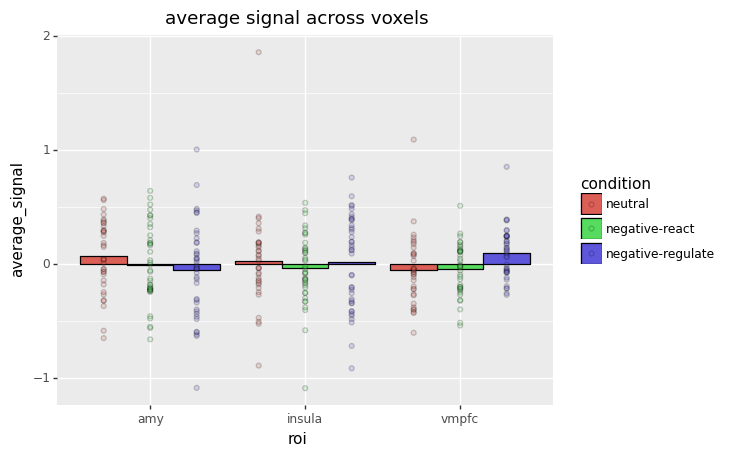

<ggplot: (-9223371866964652884)>


C:\ProgramData\Miniconda3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6 x 4.5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\ProgramData\Miniconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures/average_signal_roi1
  warn('Filename: {}'.format(filename), PlotnineWarning)


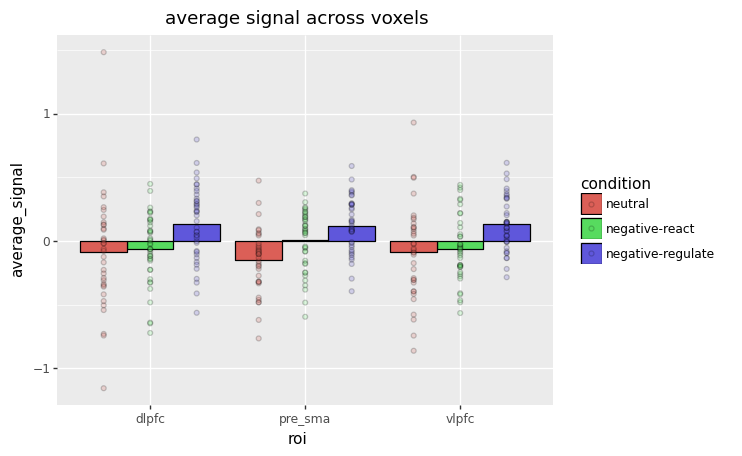

<ggplot: (169786338217)>


C:\ProgramData\Miniconda3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6 x 4.5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\ProgramData\Miniconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures/average_signal_roi2
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [172]:
# plot average signal in the ROIs
imported_data = {'amy': data_sub_16034['amy']['data'].mean(axis = 1),
                'insula': data_sub_16034['insula']['data'].mean(axis = 1),
                'vmpfc': data_sub_16034['vmpfc']['data'].mean(axis = 1),
                'vlpfc': data_sub_16034['vlpfc']['data'].mean(axis = 1),
                'dlpfc': data_sub_16034['dlpfc']['data'].mean(axis = 1),
                'pre_sma': data_sub_16034['pre_sma']['data'].mean(axis = 1),
                'acc': data_sub_16034['acc']['data'].mean(axis = 1),
                'condition':data_sub_16034['amy']['label'],
                'run':data_sub_16034['amy']['run']}

df_imported_data = pd.DataFrame(data = imported_data)

df_imported_data_long = pd.melt(df_imported_data, 
        id_vars=['condition'],
        value_vars=['amy', 'insula', 'vmpfc', 'dlpfc', 'vlpfc', 'pre_sma', 'acc'],
        var_name='roi', value_name='average_signal')

df_imported_data_long['condition'] = pd.Categorical(df_imported_data_long['condition'], categories=["neutral", "negative-react", "negative-regulate"])

df_imported_data_long1 = df_imported_data_long[df_imported_data_long['roi'].isin(['amy', 'insula', 'vmpfc'])]
df_imported_data_long2 = df_imported_data_long[df_imported_data_long['roi'].isin(['dlpfc', 'vlpfc', 'pre_sma'])]

# ggplot
p_roi1 = (ggplot(df_imported_data_long1, aes('roi', 'average_signal', fill = 'condition')) +\
stat_summary(fun_y = np.mean,
                geom = 'bar',
                color = 'black',
                position = position_dodge(width = .9)) +\
geom_point(alpha = .2, position = position_dodge(width = .9)) +\
# stat_summary(fun_data = 'mean_cl_boot', 
#                 geom = 'linerange',
#                 position = position_dodge(width = .9)) +\
labs(title = 'average signal across voxels'))
print(p_roi1)

ggsave(filename='figures/average_signal_roi1', plot=p_roi1, 
       width = 6, height = 4.5, device='png', dpi=300)

# ggplot
p_roi2 = (ggplot(df_imported_data_long2, aes('roi', 'average_signal', fill = 'condition')) +\
stat_summary(fun_y = np.mean,
                geom = 'bar',
                color = 'black',
                position = position_dodge(width = .9)) +\
geom_point(alpha = .2, position = position_dodge(width = .9)) +\
# stat_summary(fun_data = 'mean_cl_boot', 
#                 geom = 'linerange',
#                 position = position_dodge(width = .9)) +\
labs(title = 'average signal across voxels'))
print(p_roi2)

ggsave(filename='figures/average_signal_roi2', plot=p_roi2, 
       width = 6, height = 4.5, device='png', dpi=300)

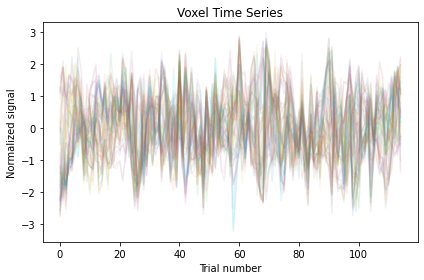

In [120]:
# visualize data of 16034
plt.plot(data_sub_16034['amy']['data'][:, :50], alpha = .1)
# plt.plot(data_sub_16034['data'][:, -50:], alpha = .1)

plt.title('Voxel Time Series')
plt.xlabel('Trial number')
plt.ylabel('Normalized signal')
plt.tight_layout()

# plt.savefig('figures/data_time_series_insula.png', dpi = 200)

In [7]:
from sklearn.decomposition import PCA as sklearn_PCA

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


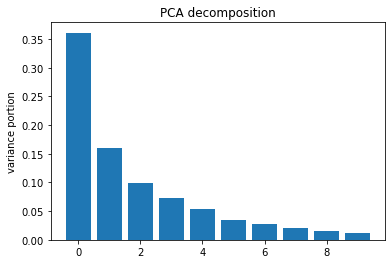

In [158]:
# eigen values
cov_mat = np.dot(data_sub_16034['vlpfc']['data'].T, data_sub_16034['vlpfc']['data'])
eig_vals = np.linalg.eigvals(cov_mat)
# print(eig_vals)

eig_vals_to_plot = eig_vals[:10] / np.sum(eig_vals)
y_pos = np.arange(len(eig_vals_to_plot))
plt.bar(y_pos, eig_vals_to_plot, align='center')
plt.ylabel('variance portion')
plt.title('PCA decomposition')
# plt.show()

plt.savefig('figures/eig_vals_vlpfc.png', dpi = 200)

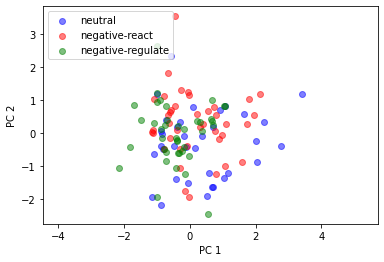

In [161]:
# PCA
cls = sklearn_PCA(n_components=3, whiten=True)
cls.fit(data_sub_16034['vlpfc']['data'])

Xproj = cls.transform(data_sub_16034['vlpfc']['data'])

category_subset = np.array(data_sub_16034['vlpfc']['label'])
cat1 = 'neutral'
cat2 = 'negative-react'
cat3 = 'negative-regulate'

x = Xproj[:, 0]
y = Xproj[:, 1]
z = Xproj[:, 2]

xb = x[category_subset == cat1]
yb = y[category_subset == cat1]
zb = z[category_subset == cat1]
xc = x[category_subset == cat2]
yc = y[category_subset == cat2]
zc = z[category_subset == cat2]
xd = x[category_subset == cat3]
yd = y[category_subset == cat3]
zd = z[category_subset == cat3]

plt.scatter(xb, yb, color='b', label=cat1, alpha = .5)
plt.scatter(xc, yc, color='r', label=cat2, alpha = .5)
plt.scatter(xd, yd, color='g', label=cat3, alpha = .5)
plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'upper left')

plt.savefig('figures/2d_visualization_vlpfc.png', dpi = 200)

# # 3D plot
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# plt.scatter(xb, yb, zb, color='b', label=cat1, marker='o')
# plt.scatter(xc, yc, zc, color='r', label=cat2, marker='o')
# plt.scatter(xd, yd, zd, color='g', label=cat3, marker='o')
# ax.set_xlabel('PC 1')
# ax.set_ylabel('PC 2')
# ax.set_zlabel('PC 3')

# plt.show()

### Classification

In [8]:
def get_splits(metadata,
               split_by_func,
               num_splits,
               num_per_class_test,
               num_per_class_train,
               train_filter=None,
               test_filter=None,
               seed=0):
    """
    construct a consistent set of splits for cross validation
    
    arguments: 
        metadata: numpy.rec.array of metadata 
        split_by_func: callable, returns label for spliting data into balanced categories 
                       when applied to metadata
        num_per_class_test: number of testing examples for each unique 
                            split_by category
        num_per_class_train: number of train examples for each unique 
                            split_by category
        train_filter: callable (or None): specifying which subset of the data 
                 to use in training applied on a per-element basis to metadata
        test_filter: callable (or None): specifying which subset of the data 
                 to use in testing applied on a per-element basis to metadata
        seed: seed for random number generator
    """
    
    #define helper function for filtering metadata by desired filter
    def get_possible_inds(metadata, filter):
        inds = np.arange(len(metadata))
        if filter is not None:
            subset = np.array(map(filter, metadata)).astype(np.bool)
            inds = inds[subset]
        return inds
    
    #filter the data by train and test filters
    train_inds = get_possible_inds(metadata, train_filter)
    test_inds = get_possible_inds(metadata, test_filter)
    
    #construct possibly category labels for balancing data
    labels = split_by_func(metadata)
    #for later convenience, get unique values of splitting labels in train and test data
    unique_train_labels = np.unique(labels[train_inds])
    unique_test_labels = np.unique(labels[test_inds])
    
    #seed the random number generator
    rng = np.random.RandomState(seed=seed)
    
    #construct the splits one by one
    splits = []
    for _split_ind in range(num_splits):
        #first construct the testing data
        actual_test_inds = []
        #for each possible test label
        for label in unique_test_labels: 
            #look at all possible stimuli with this label
            possible_test_inds_this_label = test_inds[labels[test_inds] == label]
            #count how many there are
            num_possible_test_inds_this_label = len(possible_test_inds_this_label)
            #make sure there are enough
            err_msg = 'You requested %s per test class but there are only %d available' % (
                    num_per_class_test, num_possible_test_inds_this_label)
            assert num_possible_test_inds_this_label >= num_per_class_test, err_msg
            #select num_per_class_test random examples
            perm = rng.permutation(num_possible_test_inds_this_label)
            actual_test_inds_this_label = possible_test_inds_this_label[
                                                      perm[ :num_per_class_test]]
            actual_test_inds.extend(actual_test_inds_this_label)
        actual_test_inds = np.sort(actual_test_inds)
        
        #now, since the pools of possible train and test data overlap, 
        #but since we don't want the actual train and data examples to overlap at all,
        #remove the chosen test examples for this split from the pool of possible 
        #train examples for this split
        remaining_available_train_inds = np.unique(list(set(
                           train_inds).difference(actual_test_inds)))
        
        #now contruct the train portion of the split
        #basically the same way as for the testing examples
        actual_train_inds = []
        for label in unique_train_labels:
            _this_label = labels[remaining_available_train_inds] == label
            possible_train_inds_this_label = remaining_available_train_inds[_this_label]
            num_possible_train_inds_this_label = len(possible_train_inds_this_label)
            err_msg = 'You requested %s per train class but there are only %d available' % (
                  num_per_class_train, num_possible_train_inds_this_label)
            assert num_possible_train_inds_this_label >= num_per_class_train, err_msg
            perm = rng.permutation(num_possible_train_inds_this_label)
            actual_train_inds_this_label = possible_train_inds_this_label[
                                                      perm[ :num_per_class_train]]
            actual_train_inds.extend(actual_train_inds_this_label)
        actual_train_inds = np.sort(actual_train_inds)
        
        split = {'train': actual_train_inds, 'test': actual_test_inds}
        splits.append(split)
        
    return splits


def validate_splits(splits, labels):
    train_classes = np.unique(labels[splits[0]['train']])
    for split in splits:
        train_inds = split['train']
        test_inds = split['test']
        assert set(train_inds).intersection(test_inds) == set([])
        train_labels = labels[split['train']]
        test_labels = labels[split['test']]
        assert (np.unique(train_labels) == train_classes).all()
        assert set(test_labels) <= set(train_classes)
    return train_classes

def featurewise_norm(data, fmean=None, fvar=None):
    """perform a whitening-like normalization operation on the data, feature-wise
       Assumes data = (K, M) matrix where K = number of stimuli and M = number of features
    """
    if fmean is None:
        fmean = data.mean(0)
    if fvar is None:
        fvar = data.std(0)
    data = data - fmean  #subtract the feature-wise mean of the data
    data = data / np.maximum(fvar, 1e-5)  #divide by the feature-wise std of the data
    return data, fmean, fvar

def visualize_confmat(cmat, ucats, fig=None):
    cmat = cmat.astype(float) / cmat.sum(0)
    plt.figure(figsize=(6, 4))
    if fig is None:
        plt.matshow(cmat, fignum=1)
    else:
        fig.gca().matshow(cmat, fignum=1)
    for i in range(cmat.shape[0]):
        for j in range(cmat.shape[1]):
            plt.text(j-.1, i, '%.2f%%' % (cmat[i, j] * 100), color='w')
    M = len(ucats)
    plt.xticks(np.arange(M), ucats)
    plt.yticks(np.arange(M), ucats)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

In [9]:
from sklearn.model_selection import GridSearchCV
import metrics 

def train_and_test_scikit_classifier(features, 
                                     labels,
                                     splits,
                                     model_class,
                                     model_args=None,
                                     gridcv_params=None,                                     
                                     feature_norm=True,
                                     return_models=False,
                                     select_feature=True,
                                    ):
    """Routine for contructing, training and testing correlation classifier
       
       Arguments: 
           features: (K, M) feature array where K = number of stimuli and M = number of features
           labels: length-K vector of labels to be predicted
           splits: splits of data (constructed by calling the get_splits function)
           model_class: the actual live pythone object that is the classifier "class" object
           model_args: dictionary of arguments for instantiating the classifier class obejct
           gridcv_params: dictionary of params for applying gridSearch cross-validation to
           feature_norm: apply featurewise_norm
           return_models: return actual trained models for each split
           select_feature: whether to select 100 most predictive features based on correlation in train data
           
       Returns:
           dictionary summary of training and testing results
    
    """
    train_confmats = []
    test_confmats = []
    
    if model_args is None:
        model_args = {}
    
    training_sidedata = []
    train_classes = validate_splits(splits, labels)
    
    models = []
    
    for split in splits:

        #here we instantiate the general classifier, whatever it is    
        model = model_class(**model_args)
    
        if gridcv_params is not None:
            model = GridSearchCV(model, gridcv_params)

        train_inds = split['train']
        test_inds = split['test']
        train_features = features[train_inds]
        train_labels = labels[train_inds]
        test_features = features[test_inds]
        test_labels = labels[test_inds]
        
        if select_feature:
            label1 =(np.array(train_labels) == 'neutral')
            label2 =(np.array(train_labels) == 'negative-react')
            label3 =(np.array(train_labels) == 'negative-regulate')

            cor_label1 = np.array([stats.pearsonr(train_features[:, i], label1)[0] 
                                         for i in range(train_features.shape[1])])
            cor_label2 = np.array([stats.pearsonr(train_features[:, i], label2)[0] 
                                         for i in range(train_features.shape[1])])
            cor_label3 = np.array([stats.pearsonr(train_features[:, i], label3)[0] 
                                         for i in range(train_features.shape[1])])

            # get the idx of 100 largest voxels
            idx_best_vox1 = np.argsort(np.absolute(cor_label1))[-100:]
            idx_best_vox2 = np.argsort(np.absolute(cor_label2))[-100:]
            idx_best_vox3 = np.argsort(np.absolute(cor_label3))[-100:]
            idx_best_vox = np.append(idx_best_vox1, [idx_best_vox2, idx_best_vox3])
            idx_best_vox_unique = np.unique(idx_best_vox)
            
            train_features = train_features[:, idx_best_vox_unique]
            test_features = test_features[:, idx_best_vox_unique]

        if feature_norm:
            train_features, fmean, fvar = featurewise_norm(train_features)
            sidedata = {'fmean': fmean, 'fvar': fvar}
            training_sidedata.append(sidedata)
        
        model.fit(train_features, train_labels)
        classes_ = model.classes_
        assert set(model.classes_) == set(train_classes)
        sidedata['classes_'] = classes_
        
        train_predictions = model.predict(train_features)
        train_confmat = metrics.get_confusion_matrix(train_predictions, 
                                                     train_labels, 
                                                     train_classes)
        train_confmats.append(train_confmat)
                
        if feature_norm:
            test_features, _ignore, _ignore = featurewise_norm(test_features,
                                                               fmean=fmean,
                                                               fvar=fvar)
            
        test_predictions = model.predict(test_features)
        test_confmat = metrics.get_confusion_matrix(test_predictions, test_labels, train_classes)
        test_confmats.append(test_confmat)
        
        if return_models:
            models.append(model)
        
    train_confmats = np.array(train_confmats)
    train_results = metrics.evaluate_results(train_confmats, train_classes)
    test_confmats = np.array(test_confmats)
    test_results = metrics.evaluate_results(test_confmats, train_classes)
    results = {'train': train_results,
               'test': test_results,
               'training_sidedata': training_sidedata}
    if return_models:
            results['models'] = models
            
    return results, train_classes

In [10]:
# get meta data
meta_sub_16034_reactivity = {}
meta_sub_16034_reactivity['label'] = data_sub_16034['amy_reactivity']['label']
meta_sub_16034_reactivity['run'] = data_sub_16034['amy_reactivity']['run']

meta_array_reactivity = np.core.records.fromarrays(meta_sub_16034_reactivity.values(), 
                                        names=list(meta_sub_16034_reactivity.keys())[0] + ',' +list(meta_sub_16034_reactivity.keys())[1])


meta_sub_16034_regulation = {}
meta_sub_16034_regulation['label'] = data_sub_16034['amy_regulation']['label']
meta_sub_16034_regulation['run'] = data_sub_16034['amy_regulation']['run']

meta_array_regulation = np.core.records.fromarrays(meta_sub_16034_regulation.values(), 
                                        names=list(meta_sub_16034_regulation.keys())[0] + ',' +list(meta_sub_16034_regulation.keys())[1])

In [12]:
meta_sub_16034_reactivity

{'label': array(['negative-react', 'neutral', 'neutral', 'negative-react',
        'neutral', 'neutral', 'negative-react', 'negative-react',
        'negative-react', 'neutral', 'negative-react', 'neutral',
        'neutral', 'negative-react', 'negative-react', 'negative-react',
        'negative-react', 'negative-react', 'negative-react', 'neutral',
        'neutral', 'negative-react', 'neutral', 'negative-react',
        'negative-react', 'negative-react', 'neutral', 'neutral',
        'neutral', 'neutral', 'neutral', 'neutral', 'negative-react',
        'negative-react', 'neutral', 'neutral', 'negative-react',
        'negative-react', 'negative-react', 'neutral', 'negative-react',
        'neutral', 'negative-react', 'neutral', 'negative-react',
        'neutral', 'neutral', 'neutral', 'negative-react', 'neutral',
        'negative-react', 'negative-react', 'negative-react', 'neutral',
        'negative-react', 'negative-react', 'negative-react',
        'negative-react', 'neutral'

In [13]:
splits_reactivity = get_splits(metadata=meta_array_reactivity, 
                    split_by_func=lambda x: x['label'],  #we're balancing splits by object
                    num_splits=50, 
                    num_per_class_test=5, 
                    num_per_class_train=30, 
                   )

# print(splits)

splits_regulation = get_splits(metadata=meta_array_regulation, 
                    split_by_func=lambda x: x['label'],  #we're balancing splits by object
                    num_splits=50, 
                    num_per_class_test=5, 
                    num_per_class_train=30, 
                   )


[{'train': array([ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19,
         20, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 35, 36, 37, 39, 40, 43,
         44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 57, 59, 60, 61, 62, 63, 64,
         65, 66, 67, 68, 69, 70, 71, 72, 74]),
  'test': array([ 8, 17, 34, 38, 41, 42, 50, 53, 58, 73])},
 {'train': array([ 0,  1,  2,  4,  6,  7,  9, 10, 12, 15, 17, 18, 19, 20, 21, 22, 23,
         24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44,
         45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 60, 61, 62, 63,
         64, 65, 66, 68, 69, 70, 72, 73, 74]),
  'test': array([ 3,  5, 11, 13, 14, 25, 39, 57, 59, 67])},
 {'train': array([ 1,  2,  3,  5,  6,  7,  9, 10, 13, 14, 15, 18, 19, 20, 21, 22, 23,
         24, 25, 26, 27, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43,
         45, 46, 47, 48, 49, 51, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64,
         65, 66, 68, 69, 70, 71, 72, 73, 74]),
  'test': array([ 0

### SVM classification of reactivity 

In [13]:
from sklearn.svm import LinearSVC

In [13]:
results, train_classes = train_and_test_scikit_classifier(features=data_sub_16034['vmpfc_reactivity']['data'],
                                                       labels=meta_array_reactivity['label'],
                                                       splits=splits_reactivity,
                                                       model_class=LinearSVC,
#                                                        model_args={'C':1e-3}, # Regularization parameter
                                                        gridcv_params={'C':[1e-9, 1e-7, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]},
                                                        select_feature=False
                                          )

# print(results)
print('train accuracy:', results['train']['mean_accuracy'])
print('test accuracy:', results['test']['mean_accuracy'])
print('test d-prime:', results['test']['mean_dprime'])

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

train accuracy: 0.914
test accuracy: 0.702
test d-prime: [1.06431555 1.06431555]


In [16]:
# amygdala
# train accuracy: 0.8556666666666667
# test accuracy: 0.6380000000000001
# test d-prime: [0.706246 0.706246]

# insula
# train accuracy: 0.9149999999999999
# test accuracy: 0.6719999999999999
# test d-prime: [0.89093963 0.89093963]

# vmPFC
# train accuracy: 0.914
# test accuracy: 0.702
# test d-prime: [1.06431555 1.06431555]

print(np.std(results['test']['accuracy_by_split'])/np.sqrt(50))

0.018436919482386422


Text(0.5, 1.05, '2x2 confusion matrix for reactivity classification')

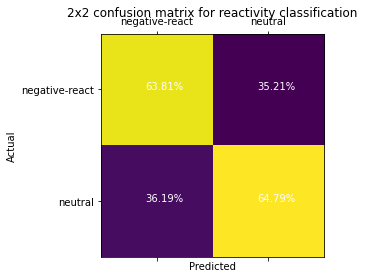

In [27]:
visualize_confmat(results['test']['confusion_matrices'].mean(0), 
                  results['test']['labels'])
plt.title('2x2 confusion matrix for reactivity classification')

# plt.savefig('figures/confus_mat_reactivity_amy.png', dpi = 200)

### SVM classification of regulation 

In [144]:
results, train_classes = train_and_test_scikit_classifier(features=data_sub_16034['insula_regulation']['data'],
                                                       labels=meta_array_regulation['label'],
                                                       splits=splits_regulation,
                                                       model_class=LinearSVC,
#                                                        model_args={'C':1e-3}, # Regularization parameter
                                                        gridcv_params={'C':[1e-9, 1e-7, 1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1]},
                                                        select_feature=False
                                          )

# print(results)
print('train accuracy:', results['train']['mean_accuracy'])
print('test accuracy:', results['test']['mean_accuracy'])
print('test d-prime:', results['test']['mean_dprime'])

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

train accuracy: 0.9106666666666666
test accuracy: 0.6060000000000001
test d-prime: [0.53945811 0.53945811]


In [ ]:
# amygdala
# train accuracy: 0.8746666666666667
# test accuracy: 0.516
# test d-prime: [0.08026999 0.08026999]

# insula
# train accuracy: 0.9106666666666666
# test accuracy: 0.6060000000000001
# test d-prime: [0.53945811 0.53945811]

# vmPFC
# train accuracy: 0.8306666666666668
# test accuracy: 0.5660000000000001
# test d-prime: [0.33291943 0.33291943]

Text(0.5, 1.05, '2x2 confusion matrix for regulation classification')

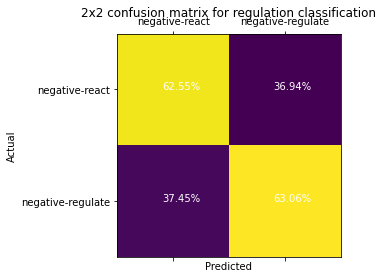

In [131]:
visualize_confmat(results['test']['confusion_matrices'].mean(0), 
                  results['test']['labels'])
plt.title('2x2 confusion matrix for regulation classification')

# plt.savefig('figures/confus_mat_regulation_amy.png', dpi = 200)

### Plot classification results

In [32]:
classicication_results = {'accuracy':[], 'roi':[], 'outcome':[]}

# for roi in ['amy', 'insula', 'vmpfc', 'dlpfc', 'vlpfc', 'pre_sma', 'acc']:
# for roi in ['frontal_pole', 'gray_matter']:
for roi in ['frontal_pole_' + str(t) + 's' for t in range(2, 14, 2)]:
    for outcome in ['reactivity', 'regulation']:
        print('Classification for ' + outcome + ' in ' + roi + ':' )
        results, train_classes = train_and_test_scikit_classifier(features=data_sub_16034[roi + '_' + outcome]['data'],
                                                               labels=eval('meta_array_' + outcome)['label'],
                                                               splits=eval('splits_' + outcome),
                                                               model_class=LinearSVC,
        #                                                        model_args={'C':1e-3}, # Regularization parameter
                                                                gridcv_params={'C':[1e-11, 1e-9, 1e-7, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]},
                                                                select_feature=False
                                                  )
        classicication_results['accuracy'].extend(results['test']['accuracy_by_split'])
        classicication_results['roi'].extend([roi] * len(results['test']['accuracy_by_split']))
        classicication_results['outcome'].extend([outcome] * len(results['test']['accuracy_by_split']))
        

Classification for reactivity in frontal_pole_2s:


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

Classification for regulation in frontal_pole_2s:


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

Classification for reactivity in frontal_pole_4s:


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

Classification for regulation in frontal_pole_4s:


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

Classification for reactivity in frontal_pole_6s:


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

Classification for regulation in frontal_pole_6s:


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

Classification for reactivity in frontal_pole_8s:


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

Classification for regulation in frontal_pole_8s:


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

Classification for reactivity in frontal_pole_10s:


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

Classification for regulation in frontal_pole_10s:


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

Classification for reactivity in frontal_pole_12s:


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

Classification for regulation in frontal_pole_12s:


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the defau

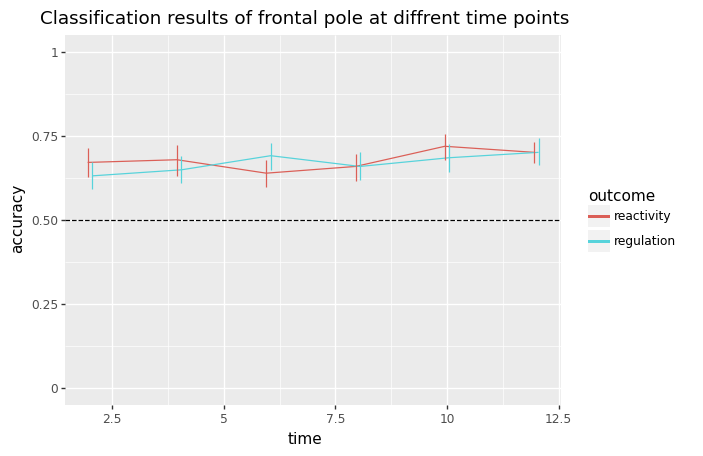

<ggplot: (-9223371895091001372)>


C:\ProgramData\Miniconda3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6 x 4.5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\ProgramData\Miniconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures/classification_roi4
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [84]:

df_classicication_results = pd.DataFrame(classicication_results)

df_classicication_results_roi1 = df_classicication_results[df_classicication_results['roi'].isin(['amy', 'insula', 'vmpfc'])]
df_classicication_results_roi2 = df_classicication_results[df_classicication_results['roi'].isin(['dlpfc', 'vlpfc', 'pre_sma'])]
df_classicication_results_roi3 = df_classicication_results[df_classicication_results['roi'].isin(['frontal_pole'])]
df_classicication_results_roi4 = df_classicication_results[df_classicication_results['roi'].isin(['frontal_pole_' + str(t) + 's' for t in range(2, 14, 2)])]
df_classicication_results_roi4['time'] = df_classicication_results_roi4['roi'].str.split('_').str.get(-1).str.slice(0, -1).astype(int)


# # ggplot
# p_roi1 = ggplot(df_classicication_results_roi1, aes('outcome', 'accuracy', fill = 'roi')) +\
# stat_summary(fun_y = np.mean,
#                 geom = 'bar',
#                 color = 'black',
#                 position = position_dodge(width = .9)) +\
# stat_summary(fun_data = 'mean_cl_boot', 
#                 geom = 'linerange',
#                 position = position_dodge(width = .9)) +\
# geom_hline(yintercept = .5, linetype = 'dashed') +\
# ylim(0,1) +\
# labs(x = "classication", title = 'Classification results')
# print(p_roi1)

# # ggsave(filename='figures/classification_roi1', plot=p_roi1, 
# #        width = 6, height = 4.5, device='png', dpi=300)


# p_roi2 = ggplot(df_classicication_results_roi2, aes('outcome', 'accuracy', fill = 'roi')) +\
# stat_summary(fun_y = np.mean,
#                 geom = 'bar',
#                 color = 'black',
#                 position = position_dodge(width = .9)) +\
# stat_summary(fun_data = 'mean_cl_boot', 
#                 geom = 'linerange',
#                 position = position_dodge(width = .9)) +\
# geom_hline(yintercept = .5, linetype = 'dashed') +\
# ylim(0,1) +\
# labs(x = "classication", title = 'Classification results')
# print(p_roi2)

# # ggsave(filename='figures/classification_roi2', plot=p_roi2, 
# #        width = 6, height = 4.5, device='png', dpi=300)


# p_roi3 = ggplot(df_classicication_results_roi3, aes('outcome', 'accuracy', fill = 'roi')) +\
# stat_summary(fun_y = np.mean,
#                 geom = 'bar',
#                 color = 'black',
#                 position = position_dodge(width = .9)) +\
# stat_summary(fun_data = 'mean_cl_boot', 
#                 geom = 'linerange',
#                 position = position_dodge(width = .9)) +\
# geom_hline(yintercept = .5, linetype = 'dashed') +\
# ylim(0,1) +\
# labs(x = "classication", title = 'Classification results')
# print(p_roi3)

# ggsave(filename='figures/classification_roi3', plot=p_roi3, 
#        width = 6, height = 4.5, device='png', dpi=300)

p_roi4 = ggplot(df_classicication_results_roi4, aes('time', 'accuracy', color = 'outcome')) +\
stat_summary(fun_y = np.mean,
                geom = 'line',
                position = position_dodge(width = .2)) +\
stat_summary(fun_data = 'mean_cl_boot', 
                geom = 'linerange',
                position = position_dodge(width = .2)) +\
geom_hline(yintercept = .5, linetype = 'dashed') +\
ylim(0,1) +\
labs(x = "time", title = 'Classification results of frontal pole at diffrent time points')
print(p_roi4)
ggsave(filename='figures/classification_roi4', plot=p_roi4, 
       width = 6, height = 4.5, device='png', dpi=300)